In [1]:
'''
Programmer: Mike Kovacevich
Last edited: 11/1/20
E-mail: mgk56@drexel.edu

Stacking sensitivity for different time windows and different gamma (spectral indices). Gamma will range from 2-3 and the time windows will range from 10^(-2) seconds to 10^5 seconds. Stacking sensitivity will be performed with Csky likelihood software.  
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import argparse
import histlite as hl
import csky as cy

cy.plotting.mrichman_mpl()

timer = cy.timing.Timer()
time = timer.time

/home/mkovacevich/py3venv/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/mkovacevich/py3venv/lib/python3.7/site-packages/csky/plotting.py:92: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  r'\SetSymbolFont{operators}   {sans}{OT1}{cmss} {m}{n}'


In [2]:
gamma = 2.0
dt = 0.01

FRB_mjd_time = [57760.83732799769, 57547.161818148146, 57488.35670925926, 57464.37542280093, 57389.35323349537, 57386.67762181713, 57362.262416412035, 57241.74578506944, 57183.22707634259, 57130.18688260417, 57068.86228835648, 56791.718183564815, 56600.752907407405, 56502.376286921295, 56471.165279837965, 56469.62221957176, 56202.5481300463, 55953.341223668984, 55745.79144221065, 55738.89811894676, 55704.629394675925, 55612.080417777775]

FRB_ra_rad = [2.979102500229121, 1.992642407001926, 2.2750366799746087, 2.0673424989872835, 5.928883469024737, 2.534392606820966, 5.067563483165536, 5.945115031068284, 2.811899957888065, 1.9050268785518107, 4.788485335771643, 5.9082885838512045, 1.7634806762150708, 3.5838590860451562, 2.369458992507502, 4.306948995146407, 4.776966162708479, 6.087184832180623, 6.1559508047091995, 5.514018705825685, 5.695009349257497, 5.910732044803997]

FRB_dec_rad = [-0.08691739674931762, -0.6841690667817772, 0.10611601852125524, -0.4954989746411902, -0.5204571829447091, -0.0445058959258554, -0.06754424205218056, -0.9585348251952858, -0.6965609044709369, -0.33143802495372315, -0.054105206811824215, -0.2040289895581371, -0.8852309966115239, -0.06981317007977318, 0.060039326268604934, -0.11414453308042916, -1.4800392056911915, -0.3066543495754037, -0.01972222054753592, -0.755029434412747, 0.00027925268031909274, -0.20245819323134223]

FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.

#Building/loading MESC data from analysis directory
ana_dir = cy.utils.ensure_dir('/data/user/mkovacevich/FRB_analysis/cascades_ana')
repo = cy.selections.Repository()
ana = cy.analysis.Analysis(repo, cy.selections.MESEDataSpecs.mesc_7yr, dir=ana_dir)

cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 10

src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient"} #,'flux': cy.hyp.PowerLawFlux(gamma)}

In [22]:
a = ana.anas[0]
#np.percentile(a.data.energy, 5)
np.percentile(a.data.energy, 95)

58064.80957031249

In [3]:
with time('background estimation'):
    allE_tr = cy.get_trial_runner(conf, ana=ana, src=src)
    bg = cy.dists.TSD(allE_tr.get_many_fits(10000, mp_cpus=10))

Performing 10000 background trials using 10 cores:
      10000/10000 trials complete.   

0:00:04.089460 elapsed.


In [4]:
# you could also use np.logspace()
Ebins = 10**np.r_[3:7.1:.25]
trs = [
    cy.get_trial_runner(conf, 
        ana=ana, src=src,
        flux=cy.hyp.PowerLawFlux(gamma, energy_range=(Emin, Emax)))
    for (Emin, Emax) in zip(Ebins[:-1], Ebins[1:])
]

In [7]:
senss = []

with time('differential sensitivity'):
    for (Emin, Emax, tr) in zip(Ebins[:-1], Ebins[1:], trs):
        print(f'log10(E) bin: {np.log10(Emin), np.log10(Emax)}')
        sens = tr.find_n_sig(
            0, .9, batch_size=500, max_batch_size=500,
            seed=1, mp_cpus=10)
        # N.B. must set E0 to a value within the energy_range
        # of the flux for this trial runner
        sens['E2dNdE'] = tr.to_E2dNdE(sens, E0=Emin)
        senss.append(sens)

log10(E) bin: (3.0, 3.25)
Start time: 2021-01-11 12:05:26.122016
Using 10 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 3.000 ... frac = 0.94000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    1.20    2.40    3.60    4.80    6.00  |  n_sig(relative error)
500      |          0.0%   70.0%   91.6%   97.8%   99.6%   99.8%  |      2.231 (+/-  4.7%) [spline]
End time: 2021-01-11 12:06:56.780532
Elapsed time: 0:01:30.658516
log10(E) bin: (3.25, 3.5)
Start time: 2021-01-11 12:06:56.782573
Using 10 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 3.000 ... frac = 0.94000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    1.20    2.40    3.60    4.80    6.00  |  n_sig(relative error)
500      |          0.0%   70.0%   91.6%   97.8%   99.6%   99.8%  |      2.231 (+/-  4.7%) [spline]
End time: 2021-01-11 12:08:49.988808
Elapsed time: 0:01:53.206235
log10(E) bin: (3.5, 3.75)
Start time: 2021-01-11

In [8]:
fluxs = [s['E2dNdE']/1e3 for s in senss] # convert GeV->TeV
diffsens = hl.Hist(Ebins, fluxs)
diffsens

Hist(16 bins in [1000.0,10000000.0], with sum 0.19881000595459553, 0 empty bins, and 0 non-finite values)

In [31]:
gamma = 2.0
dt = np.logspace(-2, 5, 8)

a = ana.anas[0]
#np.percentile(a.data.energy, 2.5)
np.percentile(a.data.energy, 97.5)

119379.24394531248

In [4]:
'''
Overlaying the sensitivities from Metzger, Margalit and Fang
'''

#Loading extracted data into arrays
energy_non_thermal_one_s = np.load('energy_non_thermal_one_s.npy', allow_pickle = True)
energy_non_thermal_ten_s = np.load('energy_non_thermal_ten_s.npy', allow_pickle = True)
energy_non_thermal_onehundred_ms = np.load('energy_non_thermal_onehundred_ms.npy', allow_pickle = True)
energy_non_thermal_ten_ms = np.load('energy_non_thermal_ten_ms.npy', allow_pickle = True)
energy_total_non_thermal = np.load('energy_total_non_thermal.npy', allow_pickle = True)
energy_thermal = np.load('energy_thermal.npy', allow_pickle = True)

sens_non_thermal_one_s = np.load('sens_non_thermal_one_s.npy', allow_pickle = True)
sens_non_thermal_ten_s = np.load('sens_non_thermal_ten_s.npy', allow_pickle = True)
sens_non_thermal_onehundred_ms = np.load('sens_non_thermal_onehundred_ms.npy', allow_pickle = True)
sens_non_thermal_ten_ms = np.load('sens_non_thermal_ten_ms.npy', allow_pickle = True)
sens_total_non_thermal = np.load('sens_total_non_thermal.npy', allow_pickle = True)
sens_thermal = np.load('sens_thermal.npy', allow_pickle = True)


### Loading MESC 7yr Differential Sensitivities
#senss1 = senss = np.load('./Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(gamma, dt), allow_pickle=True)

In [25]:
Ebins = 10**np.r_[3:6.51:.25]
len(Ebins)

15

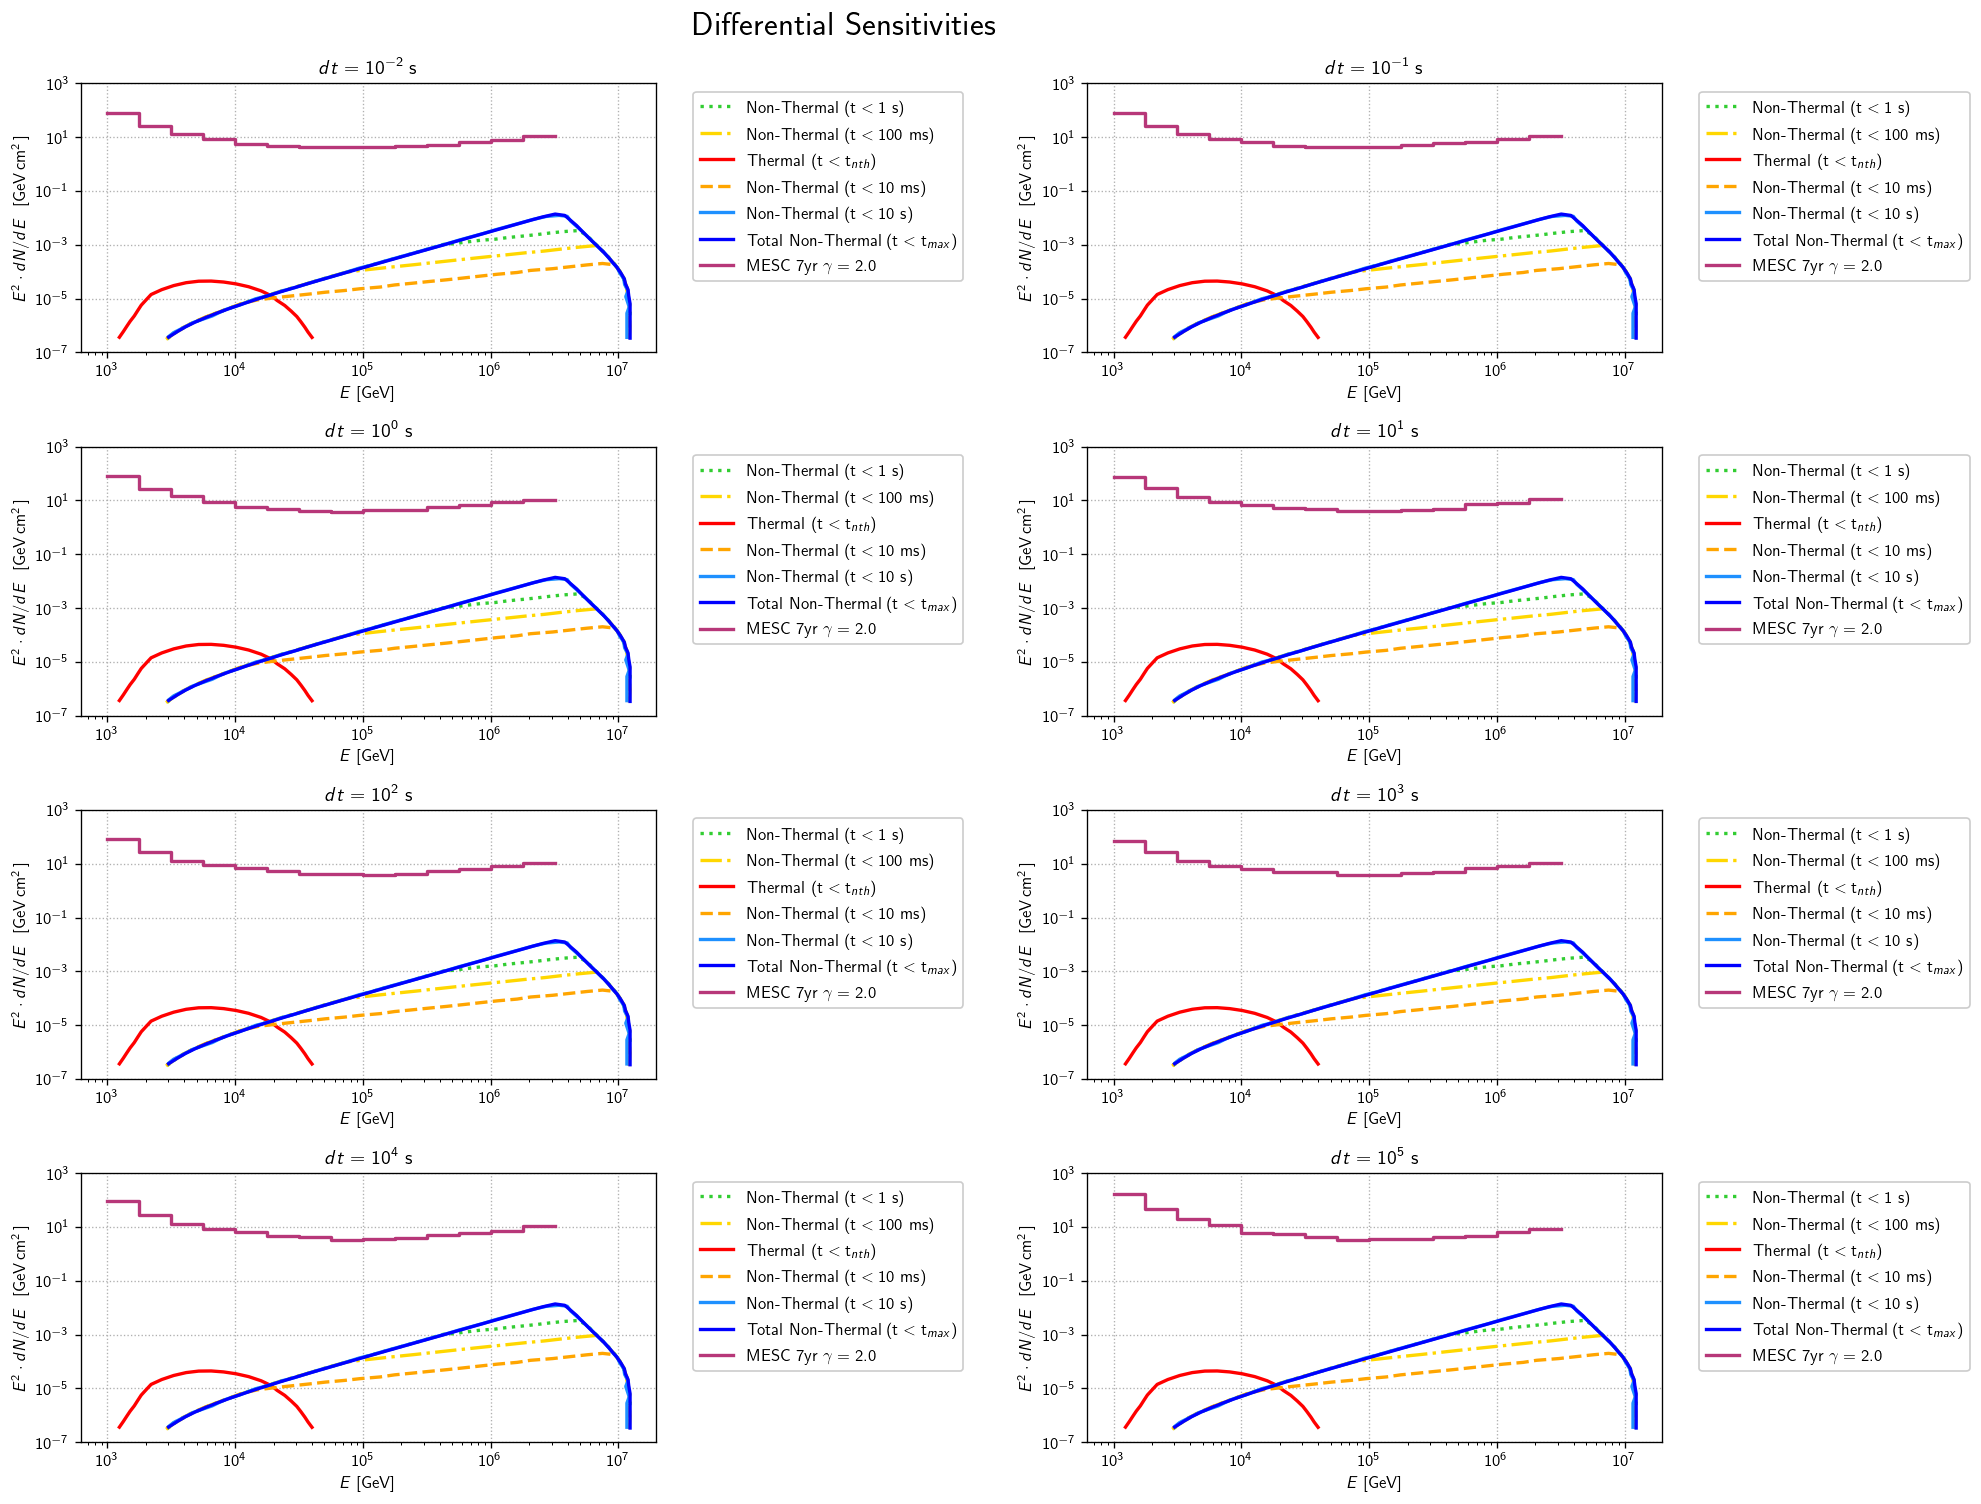

In [50]:
### Plotting overlaid Differential Sensitivities in one panel (including model spectra)

fig, axs = plt.subplots(4, 2, figsize=(17,15))

Ebins = 10**np.r_[3:6.51:.25]
#Modified_Ebins = 10**np.r_[3:5.1:.25]
gamma = [2.0]
dt = np.logspace(-2, 5, 8)

pow = np.log10(dt)
title = 'Differential Sensitivities' #: $\gamma={gamma:.1f}$ ' #, dt=10^{{{pow:.0f}}}$ s'

color_divisor = 4.0
sens_2 = {}
flux_2 = {}
diffsens_2 = {}

for (ax, i) in zip(axs.ravel(), dt):
    
    pow = np.log10(i)
    
    sens_2[i] = np.load('./Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
    flux_2[i] = [s['E2dNdE'] for s in sens_2[i]] #Units of Gev, divide by 1e3 for units of TeV
    diffsens_2[i] = hl.Hist(Ebins, flux_2[i][:14])
    hl.plot1d(ax, diffsens_2[i], label = fr'MESC 7yr $\gamma={g:.1f}$ ', color = plt.get_cmap('magma')(g/color_divisor))
    
    ax.plot(energy_non_thermal_one_s, sens_non_thermal_one_s, color = 'limegreen', ls = ':', label = r'Non-Thermal $(\text{t} < \text{1 s} )$')
    ax.plot(energy_non_thermal_onehundred_ms, sens_non_thermal_onehundred_ms, color = 'gold', ls = '-.', label = r'Non-Thermal $(\text{t} < \text{100 ms} )$')
    ax.plot(energy_thermal, sens_thermal, color = 'red', label = r'Thermal $(\text{t} < \text{t}_{nth} )$')
    ax.plot(energy_non_thermal_ten_ms, sens_non_thermal_ten_ms, color = 'orange', ls = '--', label = r'Non-Thermal $(\text{t} < \text{10 ms} )$' )
    ax.plot(energy_non_thermal_ten_s, sens_non_thermal_ten_s, color = 'dodgerblue', label = r'Non-Thermal $(\text{t} < \text{10 s} )$')
    ax.plot(energy_total_non_thermal, sens_total_non_thermal, color = 'blue', label = r'Total Non-Thermal $(\text{t} < \text{t}_{max} )$')
        #ax.axvline(np.median(t.ts), color=color,label=r'$n_\text{{inj}}={}$ median'.format(n_sig), ls='--',alpha = .6)
    ax.set(ylim = (1e-7, 1e3),
    xlabel=r'$E$ [GeV]',
    ylabel=r'$E^2\cdot dN/dE~~[\text{GeV}\,\text{cm}^2\,\text{}]$',
    title=fr'$dt=10^{{{pow:.0f}}}$ s'
    )
    #ax.set_ylim(top = 1e3)
    ax.grid()
    ax.loglog()
    ax.legend(bbox_to_anchor=(1.05, 1), prop={'size': 10})
    
fig.suptitle(title, y = .92, fontsize=20) #, fontdict = {'fontsize' : 100})
plt.subplots_adjust(wspace = .75, hspace=.35)
fig.savefig('/home/mkovacevich/public_html/plots/DiffSens/Overlaid_Differential_Sensitivity.png',bbox_inches='tight')

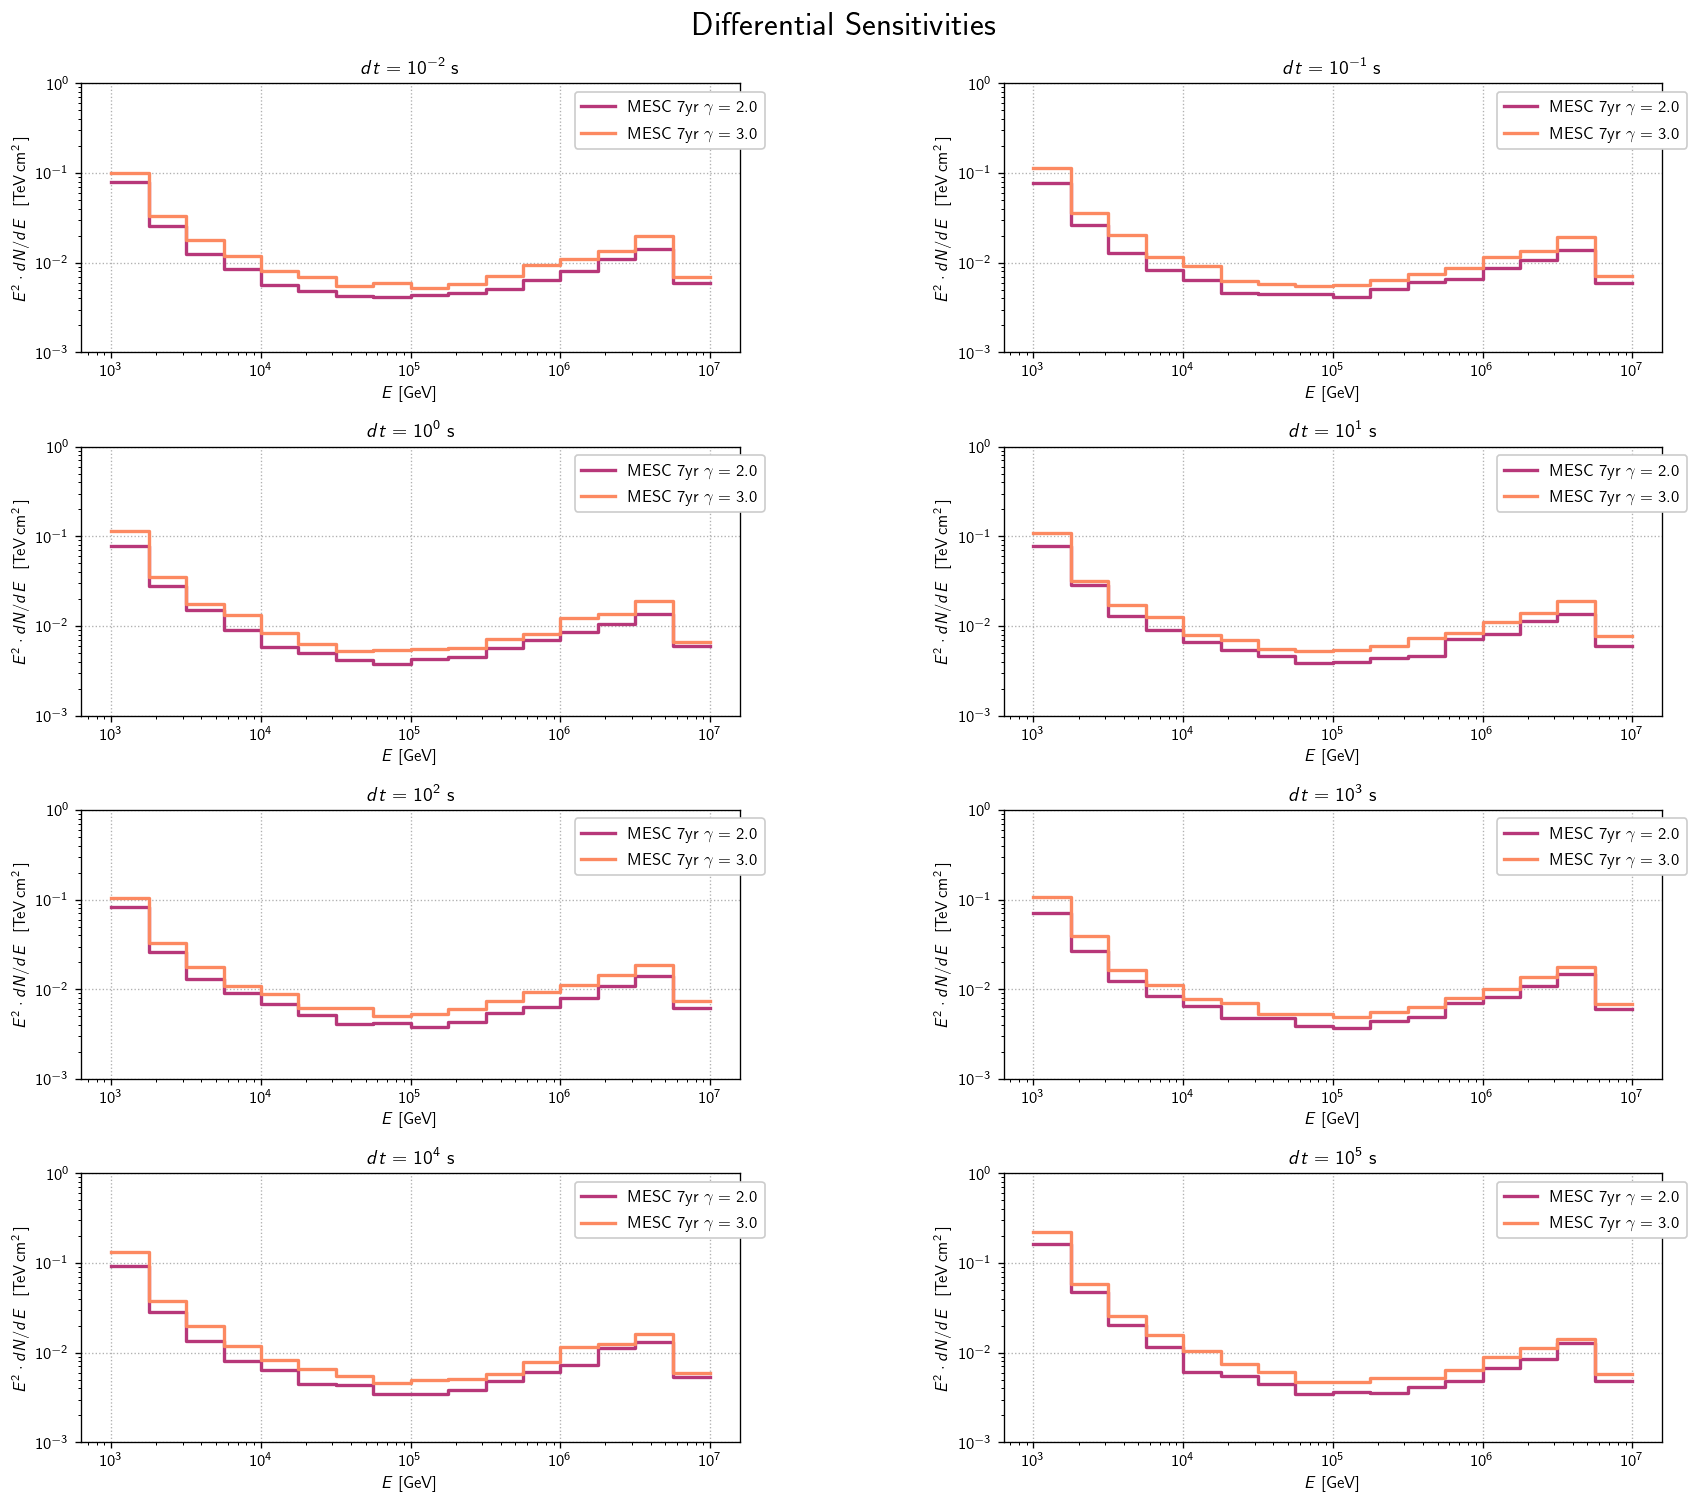

In [88]:
### Plotting Differential Sensitivities in one panel

fig, axs = plt.subplots(4, 2, figsize=(17,15))

Ebins = 10**np.r_[3:7.1:.25]
gamma = [2.0, 3.0]
dt = np.logspace(-2, 5, 8)

pow = np.log10(dt)
title = 'Differential Sensitivities' #: $\gamma={gamma:.1f}$ ' #, dt=10^{{{pow:.0f}}}$ s'

color_divisor = 4.0
sens_2 = {}
flux_2 = {}
diffsens_2 = {}



for (ax, i) in zip(axs.ravel(), dt):
    
    pow = np.log10(i)
    for g in gamma:
        if g == 2.0:
            sens_2[i] = np.load('./Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
            flux_2[i] = [s['E2dNdE']/1e3 for s in sens_2[i]] #Units of Gev, divide by 1e3 for units of TeV
            diffsens_2[i] = hl.Hist(Ebins, flux_2[i])
            hl.plot1d(ax, diffsens_2[i], label = fr'MESC 7yr $\gamma={g:.1f}$ ', color = plt.get_cmap('magma')(g/color_divisor))
            
        elif g == 3.0:
            sens_3[i] = np.load('./Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
            flux_3[i] = [s['E2dNdE']/1e3 for s in sens_3[i]] #Units of Gev, divide by 1e3 for units of TeV
            diffsens_3[i] = hl.Hist(Ebins, flux_3[i])
            hl.plot1d(ax, diffsens_3[i], label = fr'MESC 7yr $\gamma={g:.1f}$ ', color = plt.get_cmap('magma')(g/color_divisor))
    
    ax.set(ylim = (1e-3, 1e0),
    xlabel=r'$E$ [GeV]',
    ylabel=r'$E^2\cdot dN/dE~~[\text{TeV}\,\text{cm}^2\,\text{}]$',
    title=fr'$dt=10^{{{pow:.0f}}}$ s'
    )
    #ax.set_ylim(top = 1e3)
    ax.grid()
    ax.loglog()
    ax.legend(bbox_to_anchor=(1.05, 1), prop={'size': 10})
    
fig.suptitle(title, y = .92, fontsize=20) #, fontdict = {'fontsize' : 100})
plt.subplots_adjust(wspace = .4, hspace=.35)
fig.savefig('/home/mkovacevich/public_html/plots/DiffSens/Differential_Sensitivity.png',bbox_inches='tight')

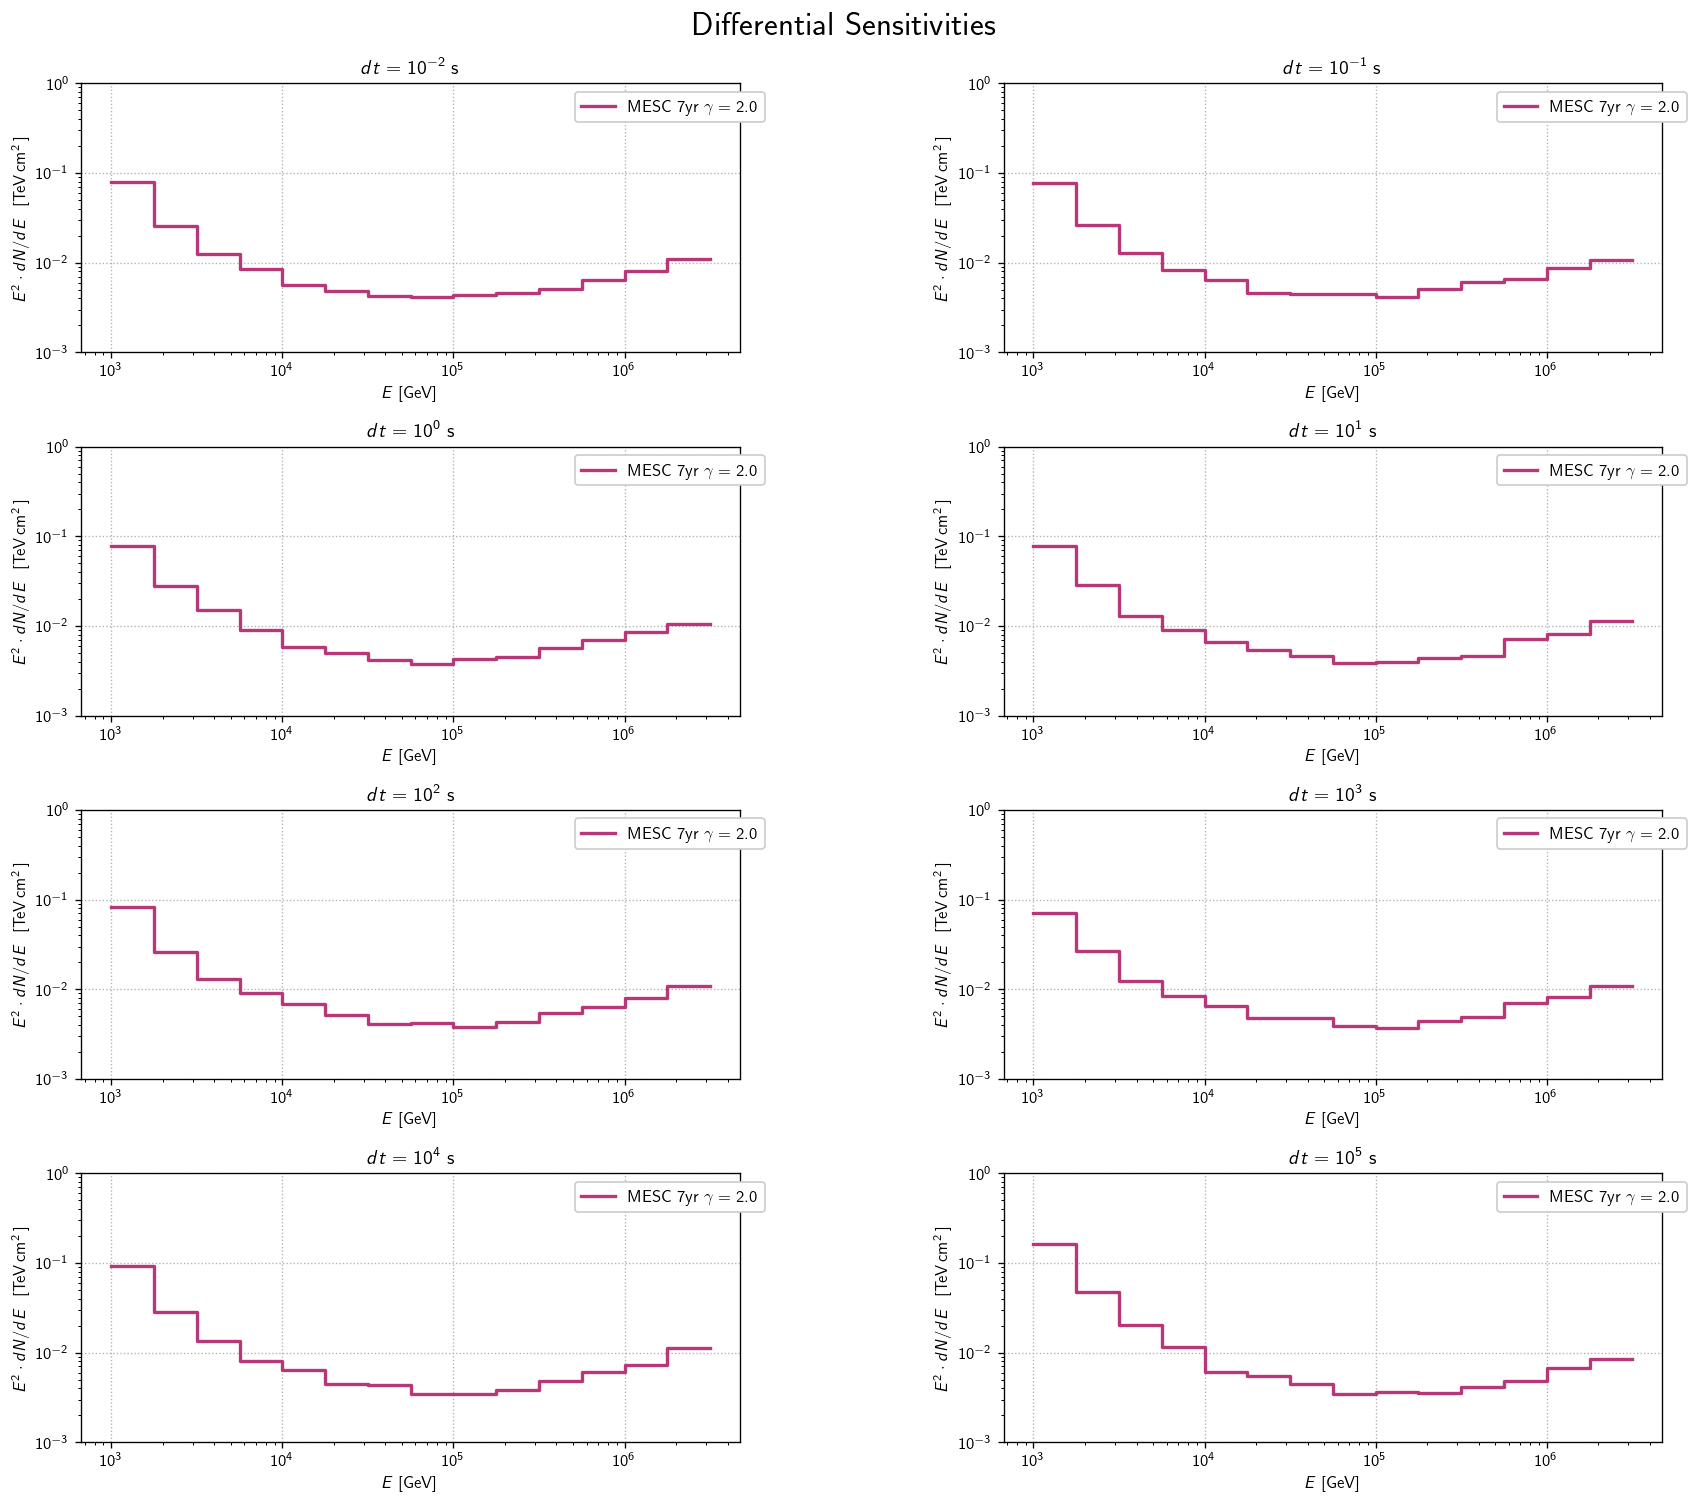

In [47]:
### Testing out using less bins at higher energies ###

fig, axs = plt.subplots(4, 2, figsize=(17,15))

Ebins = 10**np.r_[3:6.51:.25]
gamma = [2.0]
dt = np.logspace(-2, 5, 8)

pow = np.log10(dt)
title = 'Differential Sensitivities' #: $\gamma={gamma:.1f}$ ' #, dt=10^{{{pow:.0f}}}$ s'

color_divisor = 4.0
sens_2 = {}
flux_2 = {}
diffsens_2 = {}

for (ax, i) in zip(axs.ravel(), dt):
    g = 2.0
    pow = np.log10(i)


    sens_2[i] = np.load('./Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
    flux_2[i] = [s['E2dNdE']/1e3 for s in sens_2[i]] #Units of Gev, divide by 1e3 for units of TeV
    #len(flux_2[i:15])
    diffsens_2[i] = hl.Hist(Ebins, flux_2[i][:14])
    hl.plot1d(ax, diffsens_2[i], label = fr'MESC 7yr $\gamma={g:.1f}$ ', color = plt.get_cmap('magma')(g/color_divisor))
            
            
    ax.set(ylim = (1e-3, 1e0),
    xlabel=r'$E$ [GeV]',
    ylabel=r'$E^2\cdot dN/dE~~[\text{TeV}\,\text{cm}^2\,\text{}]$',
    title=fr'$dt=10^{{{pow:.0f}}}$ s'
    )
    #ax.set_ylim(top = 1e3)
    ax.grid()
    ax.loglog()
    ax.legend(bbox_to_anchor=(1.05, 1), prop={'size': 10})
    
fig.suptitle(title, y = .92, fontsize=20) #, fontdict = {'fontsize' : 100})
plt.subplots_adjust(wspace = .4, hspace=.35)
fig.savefig('/home/mkovacevich/public_html/plots/DiffSens/Differential_Sensitivity.png',bbox_inches='tight')

In [40]:
g = 2.0
i = 0.01
sens_2 = {}
flux_2 = {}
sens_2[i] = np.load('./Differential_Sensitivity_trials/DiffSens_gamma_{}_dt_{}.npy'.format(g, i), allow_pickle=True)
flux_2[i] = [s['E2dNdE']/1e3 for s in sens_2[i]]

In [44]:
flux_2[i][:10]

[0.08029897599485,
 0.025819239813181058,
 0.012540466810211244,
 0.008438720035492378,
 0.005672675435557905,
 0.004856765921362164,
 0.004286768762610439,
 0.004177391066167181,
 0.004403832694707328,
 0.004572143105149228]